In [51]:
from __future__ import division
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt
import gzip
from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from methods.xflib import xflib
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
xf = xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/rays/2d/nightside/ngo_v2/'
rayF = [200, 3920]
lat_min = 25
lat_max = 45
lon_min = 0
lon_max = 360

raydict = dict()
# plasma_model_dump = os.path.join(ray_root, 'model_dump_XY_MAG.dat')
# d_xy = readdump(plasma_model_dump)
# plasma_model_dump = os.path.join(ray_root, 'model_dump_XZ_MAG.dat')
# d_xz = readdump(plasma_model_dump)
# plasma_model_dump = os.path.join(ray_root, 'model_dump_YZ_MAG.dat')
# d_yz = readdump(plasma_model_dump)

for freq in rayF:
    print freq
    rf = read_rayfiles(ray_root,freq, lat_min, lat_max, lon_min, lon_max)


    rays = []

    for r in rf:
        tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
        tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
        tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
        tmp_coords = tmp_coords.convert('MAG','car')
        tmp_coords.sim_time = r['time']

        rays.append(tmp_coords)

    raydict[freq] = rays

['lat', 'lon']


<IPython.core.display.Javascript object>


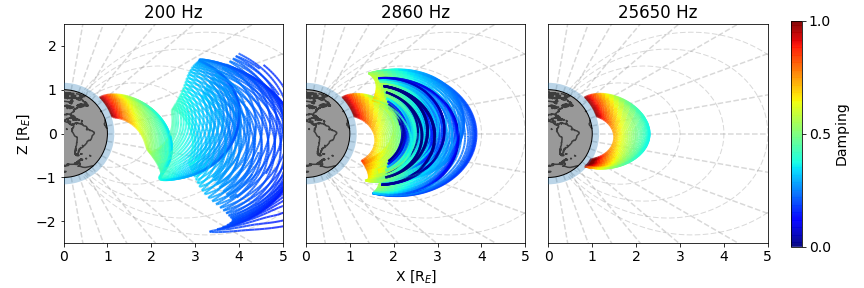

In [131]:
from matplotlib.collections import LineCollection

ray_root = '/shared/users/asousa/WIPP/rays/2d/nightside/ngo_v2/'
rayF = [200, 2860, 25650]
lat_min = 20
lat_max = 45
lon_min = 0
lon_max = 360

# --------------- Latex Plot Beautification --------------------------

fig_width = 11  # width in inches
fig_height = 3      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


H_IONO = 1000

Ne_xy = d_xy['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xy[np.isnan(Ne_xy)] = 0
Ne_xz = d_xz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xz[np.isnan(Ne_xz)] = 0
Ne_yz = d_yz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_yz[np.isnan(Ne_yz)] = 0

psize = 5
px = np.linspace(-10, 10, 200)
py = np.linspace(-10, 10, 200)


flashtime = dt.datetime(2001, 1, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

clims = [-2, 5]
# Convert to geographic coordinates for plotting:


# -------- 2D Plots -------------------

with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()



fig, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [1,1,1, 0.05]})
lcs = []

for ind, freq in enumerate(rayF):
    # Load rays
    rf = read_rayfiles(ray_root,freq, lat_min, lat_max, lon_min, lon_max)
    rays = []
    for r in rf:
        tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
        tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
        tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
        tmp_coords = tmp_coords.convert('MAG','car')
        tmp_coords.sim_time = r['time']

        rays.append(tmp_coords)


    # Plot the earth
    earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
    iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)

    ax[ind].add_patch(earth)                    # The earth (round)
    ax[ind].add_patch(iono)
    coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
    coastr = np.linalg.norm(coastpoints, axis=0)
    coastmask = (coastr < 1) | (np.isnan(coastr))
    ax[ind].plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



    for la in np.arange(-80, 81, 10):
        rr = np.array([1,10])
        ax[ind].plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)

    
    # Plot the fieldlines
    for L in [2,3,4,5,6]:
        lam = np.linspace(-80,80,181)
        L_r = L*pow(np.cos(lam*D2R),2)
        Lx  = L_r*np.cos(lam*D2R)
        Ly  = L_r*np.sin(lam*D2R)
        ax[ind].plot(Lx,Ly,color='grey',linewidth=1,linestyle='dashed',alpha=0.3, zorder=95)  # Field line


#     # Plot background density
#     p1 = ax[ind].pcolorfast(px,py,np.log10(Ne_xz), alpha=0.6, cmap=plt.get_cmap('viridis'))
#     p1.set_clim(clims)



    tmax = 15

    # Plot rays:
    for r_ind, r in enumerate(rays):

        damp = rf[r_ind]['damping']
        time = rf[r_ind]['time']

        x = (r.x[time < tmax]/R_E)
        y = (r.z[time < tmax]/R_E)
        z = (damp[time < tmax])
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=plt.get_cmap('jet'),alpha=0.8, zorder=97)
        lc.set_array(z)
        lc.set_linewidth(2)
        lc.set_clim([0,1])
        ax[ind].add_collection(lc)

    ax[ind].set_xlim([0, psize])
    ax[ind].set_ylim([-psize/2, psize/2])
    
    ax[ind].set_title('%d Hz'%freq)
    ax[ind].set_aspect('equal')
    

    
    
cax = ax[-1]
cb = plt.colorbar(lc, cax=cax)
cb.set_label('Damping')
cticks=[0,0.5,1]
cb.set_ticks(cticks)

# cb = plt.colorbar(p2, cax=cax)
# cb.set_label('Electron Density (#/cm$^3$)')
# cticks = np.arange(clims[0],clims[1] + 1)
# cb.set_ticks(cticks)
# cticklabels = ['$10^{%d}$'%k for k in cticks]
# cb.set_ticklabels(cticklabels)

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[0].set_ylabel('Z [R$_E$]')
ax[1].set_xlabel('X [R$_E$]')




fig.tight_layout()

fig.savefig('ray_families.png',dpi=150)


# fig.savefig(figtitle, ldpi=300)

In [1]:
fig, ax = plt.subplots(1,1)
ax.plot(rf[0]['time'])

NameError: name 'plt' is not defined

In [101]:
print raydict.keys()

[25650]
